In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.functional as F
from torchvision import datasets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [96]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True)

Train_images, Test_images, Train_labels, Test_labels = train_test_split(mnist_train.data, mnist_train.targets, test_size = 0.2, random_state = 42)

print(Train_images.shape)

Train_images = Train_images.numpy()
Test_images = Test_images.numpy()
Train_labels = Train_labels.numpy()
Test_labels = Test_labels.numpy()


mean = np.mean(Train_images, axis = (0,1,2))
std = np.std(Train_images, axis = (0,1,2))

Train_images = (Train_images.astype(np.float32) - np.array(mean) ) / np.array(std)
Test_images = (Test_images.astype(np.float32) - np.array(mean) ) / np.array(std)



torch.Size([48000, 28, 28])


In [97]:
Train_images_tensor = torch.tensor(Train_images, dtype = torch.float32)
Test_images_tensor = torch.tensor(Test_images, dtype = torch.float32)

Train_labels_tensor = torch.tensor(Train_labels, dtype = torch.long)
Test_labels_tensor = torch.tensor(Test_labels, dtype = torch.long)


train_dataset = TensorDataset(Train_images_tensor, Train_labels_tensor)
test_dataset = TensorDataset(Test_images_tensor, Test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [98]:
torch.manual_seed(7)


class MLP(nn.Module):
  def __init__(self,input_size, output_size):
    super(MLP,self).__init__()

    self.linear1 = nn.Linear(input_size, 56)
    self.linear2 = nn.Linear(56, 28)
    self.linear3 = nn.Linear(28, output_size)

  def forward(self,x):
    x = x.view(x.size(0), -1)
    x1 = torch.relu(self.linear1(x))
    x2 = torch.relu(self.linear2(x1))
    return self.linear3(x2)

In [99]:
def train(model, train_loader, optimizer, criterion):
  train_predictions = []
  true_labels = []
  model.train()
  total_train_loss = 0
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()

    _ , predicted = torch.max(outputs, 1)
    train_predictions.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

  accuracy = accuracy_score(true_labels,train_predictions)
  avg_loss = total_train_loss/len(train_loader)
  return accuracy, avg_loss

def evaluate(model, test_loader, criterion):
  model.eval()
  with torch.no_grad():
    test_predictions = []
    true_labels = []
    total_test_loss = 0
    for inputs, labels in test_loader:
      outputs = model(inputs)
      test_loss = criterion(outputs, labels)
      total_test_loss += test_loss.item()

      _ , predicted = torch.max(outputs, 1)
      test_predictions.extend(predicted.tolist())
      true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, test_predictions)
    avg_loss = total_test_loss / len(test_loader)
    return accuracy, avg_loss

Learning Rate: 0.5
>>Train_accuracy: 0.0945, Train_loss: 2.3089, Test_accuracy: 0.0964, Test_loss: 2.3078
>>Train_accuracy: 0.8598, Train_loss: 0.4599, Test_accuracy: 0.9291, Test_loss: 0.2439
>>Train_accuracy: 0.9420, Train_loss: 0.2033, Test_accuracy: 0.9437, Test_loss: 0.1975
>>Train_accuracy: 0.9520, Train_loss: 0.1654, Test_accuracy: 0.9512, Test_loss: 0.1817
>>Train_accuracy: 0.9584, Train_loss: 0.1472, Test_accuracy: 0.9523, Test_loss: 0.1760
>>Train_accuracy: 0.9630, Train_loss: 0.1298, Test_accuracy: 0.9480, Test_loss: 0.1882
>>Train_accuracy: 0.9656, Train_loss: 0.1213, Test_accuracy: 0.9557, Test_loss: 0.1642
>>Train_accuracy: 0.9654, Train_loss: 0.1188, Test_accuracy: 0.9603, Test_loss: 0.1498
>>Train_accuracy: 0.9704, Train_loss: 0.1050, Test_accuracy: 0.9543, Test_loss: 0.1925
>>Train_accuracy: 0.9702, Train_loss: 0.1057, Test_accuracy: 0.9587, Test_loss: 0.1655
>>Train_accuracy: 0.9721, Train_loss: 0.0971, Test_accuracy: 0.9578, Test_loss: 0.1613
>>Train_accuracy: 0.9736

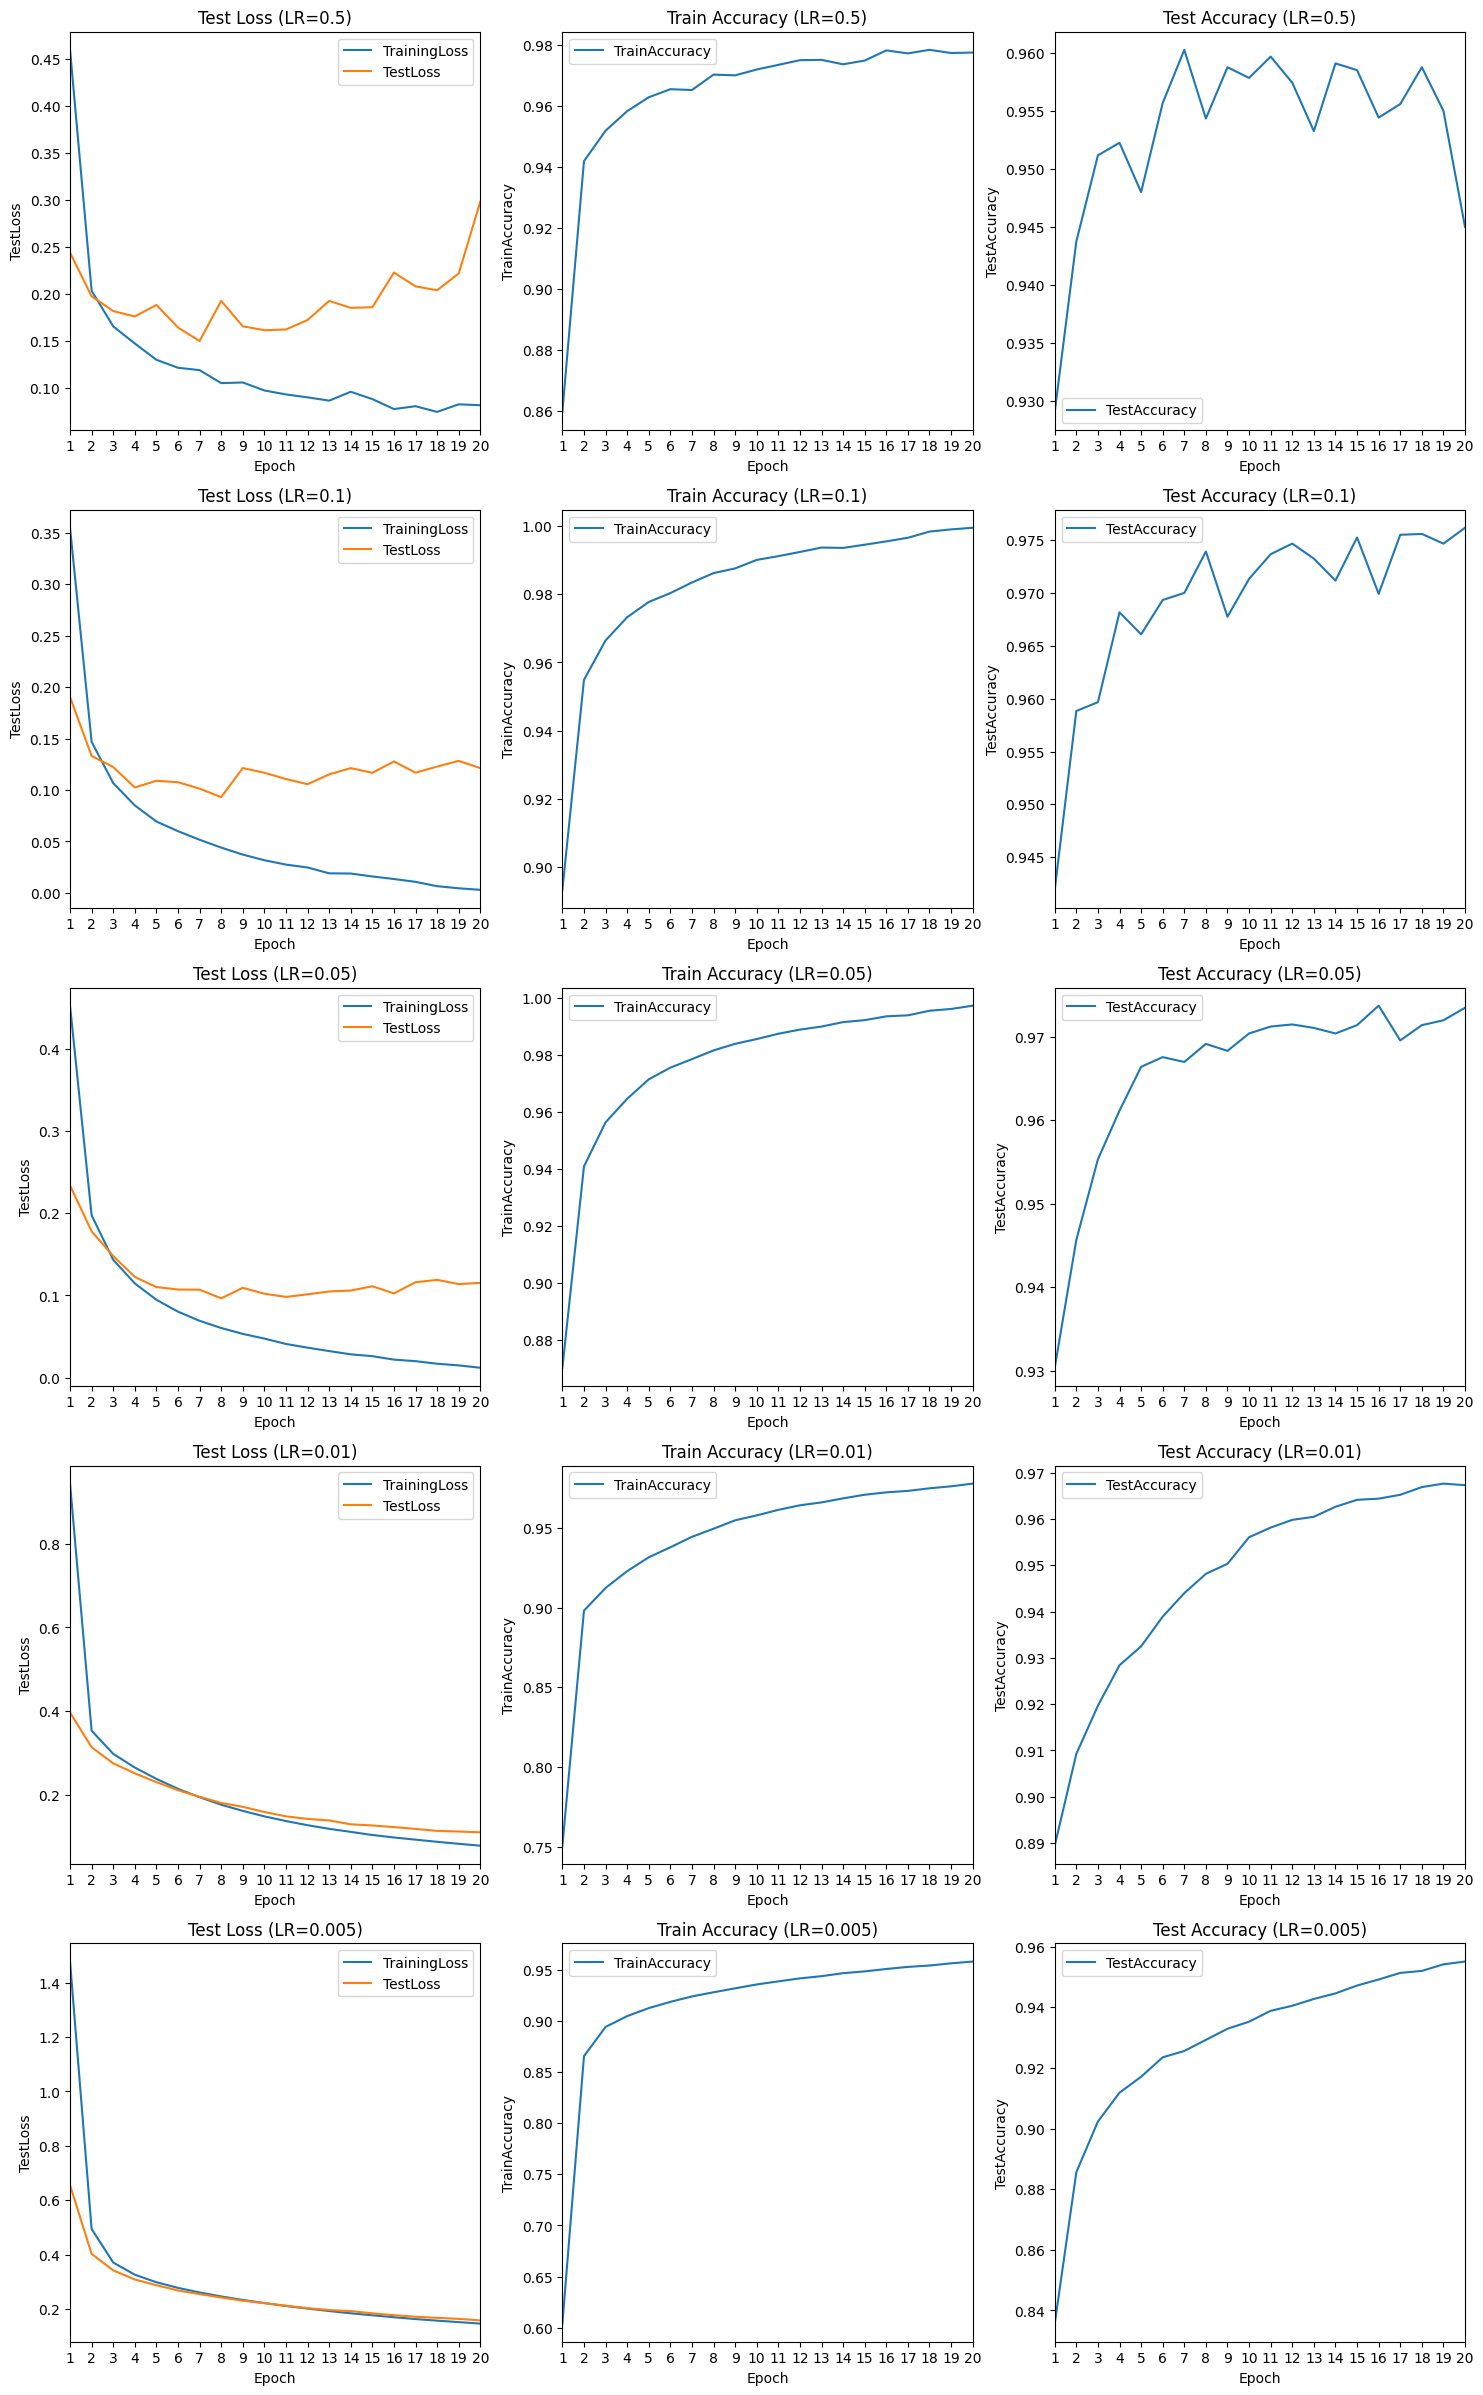

In [100]:
rates = [0.5, 0.1, 0.05, 0.01, 0.005]
inputsize = Train_images.shape[1]*Train_images.shape[2]
outputsize = 10

num_epochs = 20


fig, axs = plt.subplots(len(rates), 3, figsize=(18, 6 * len(rates)))

for i,l_rate in enumerate(rates):
  train_accuracies = []
  test_accuracies = []
  train_loss = []
  test_loss = []
  print("Learning Rate:",l_rate)

  model = MLP(inputsize, outputsize)
  optimizer = optim.SGD(model.parameters(),lr = l_rate)
  criterion = nn.CrossEntropyLoss()

  test_accuracy, testing_loss = evaluate(model, test_loader, criterion)
  training_accuracy, training_loss = evaluate(model, train_loader, criterion)

  print(">>Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(training_accuracy, training_loss, test_accuracy, testing_loss))

  for epoch in range(num_epochs):

    train_accuracy, training_loss = train(model, train_loader, optimizer, criterion)
    test_accuracy, testing_loss = evaluate(model, test_loader, criterion)

    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    train_loss.append(training_loss)
    test_loss.append(testing_loss)

    print(">>Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(train_accuracy, training_loss, test_accuracy, testing_loss))

  epochs = list(range(1, num_epochs + 1))
  axs[i,0].plot(epochs, train_loss, label = 'TrainingLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TrainingLoss')
  axs[i,0].set_title(f'Training Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,0].plot(epochs, test_loss, label = 'TestLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TestLoss')
  axs[i,0].set_title(f'Test Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,1].plot(epochs, train_accuracies, label = 'TrainAccuracy')
  axs[i,1].set_xlabel('Epoch')
  axs[i,1].set_ylabel('TrainAccuracy')
  axs[i,1].set_title(f'Train Accuracy (LR={l_rate})')
  axs[i,1].legend()
  axs[i,1].set_xticks(epochs)
  axs[i,1].set_xlim(1,num_epochs)


  axs[i,2].plot(epochs, test_accuracies, label = 'TestAccuracy')
  axs[i,2].set_xlabel('Epoch')
  axs[i,2].set_ylabel('TestAccuracy')
  axs[i,2].set_title(f'Test Accuracy (LR={l_rate})')
  axs[i,2].legend()
  axs[i,2].set_xticks(epochs)
  axs[i,2].set_xlim(1,num_epochs)


##SGD with Decay

Learning Rate: 0.5
>>Train_accuracy: 0.0984, Train_loss: 2.3166, Test_accuracy: 0.1003, Test_loss: 2.3183
>>Train_accuracy: 0.8723, Train_loss: 0.4136, Test_accuracy: 0.9443, Test_loss: 0.1888
>>Train_accuracy: 0.9429, Train_loss: 0.1985, Test_accuracy: 0.9412, Test_loss: 0.2031
>>Train_accuracy: 0.9514, Train_loss: 0.1648, Test_accuracy: 0.9488, Test_loss: 0.1731
>>Train_accuracy: 0.9538, Train_loss: 0.1551, Test_accuracy: 0.9489, Test_loss: 0.1690
>>Train_accuracy: 0.9576, Train_loss: 0.1398, Test_accuracy: 0.9477, Test_loss: 0.1854
>>Train_accuracy: 0.9578, Train_loss: 0.1401, Test_accuracy: 0.9579, Test_loss: 0.1435
>>Train_accuracy: 0.9596, Train_loss: 0.1319, Test_accuracy: 0.9615, Test_loss: 0.1338
>>Train_accuracy: 0.9595, Train_loss: 0.1374, Test_accuracy: 0.9490, Test_loss: 0.1719
>>Train_accuracy: 0.9607, Train_loss: 0.1338, Test_accuracy: 0.9597, Test_loss: 0.1414
>>Train_accuracy: 0.9608, Train_loss: 0.1278, Test_accuracy: 0.9609, Test_loss: 0.1357
>>Train_accuracy: 0.9632

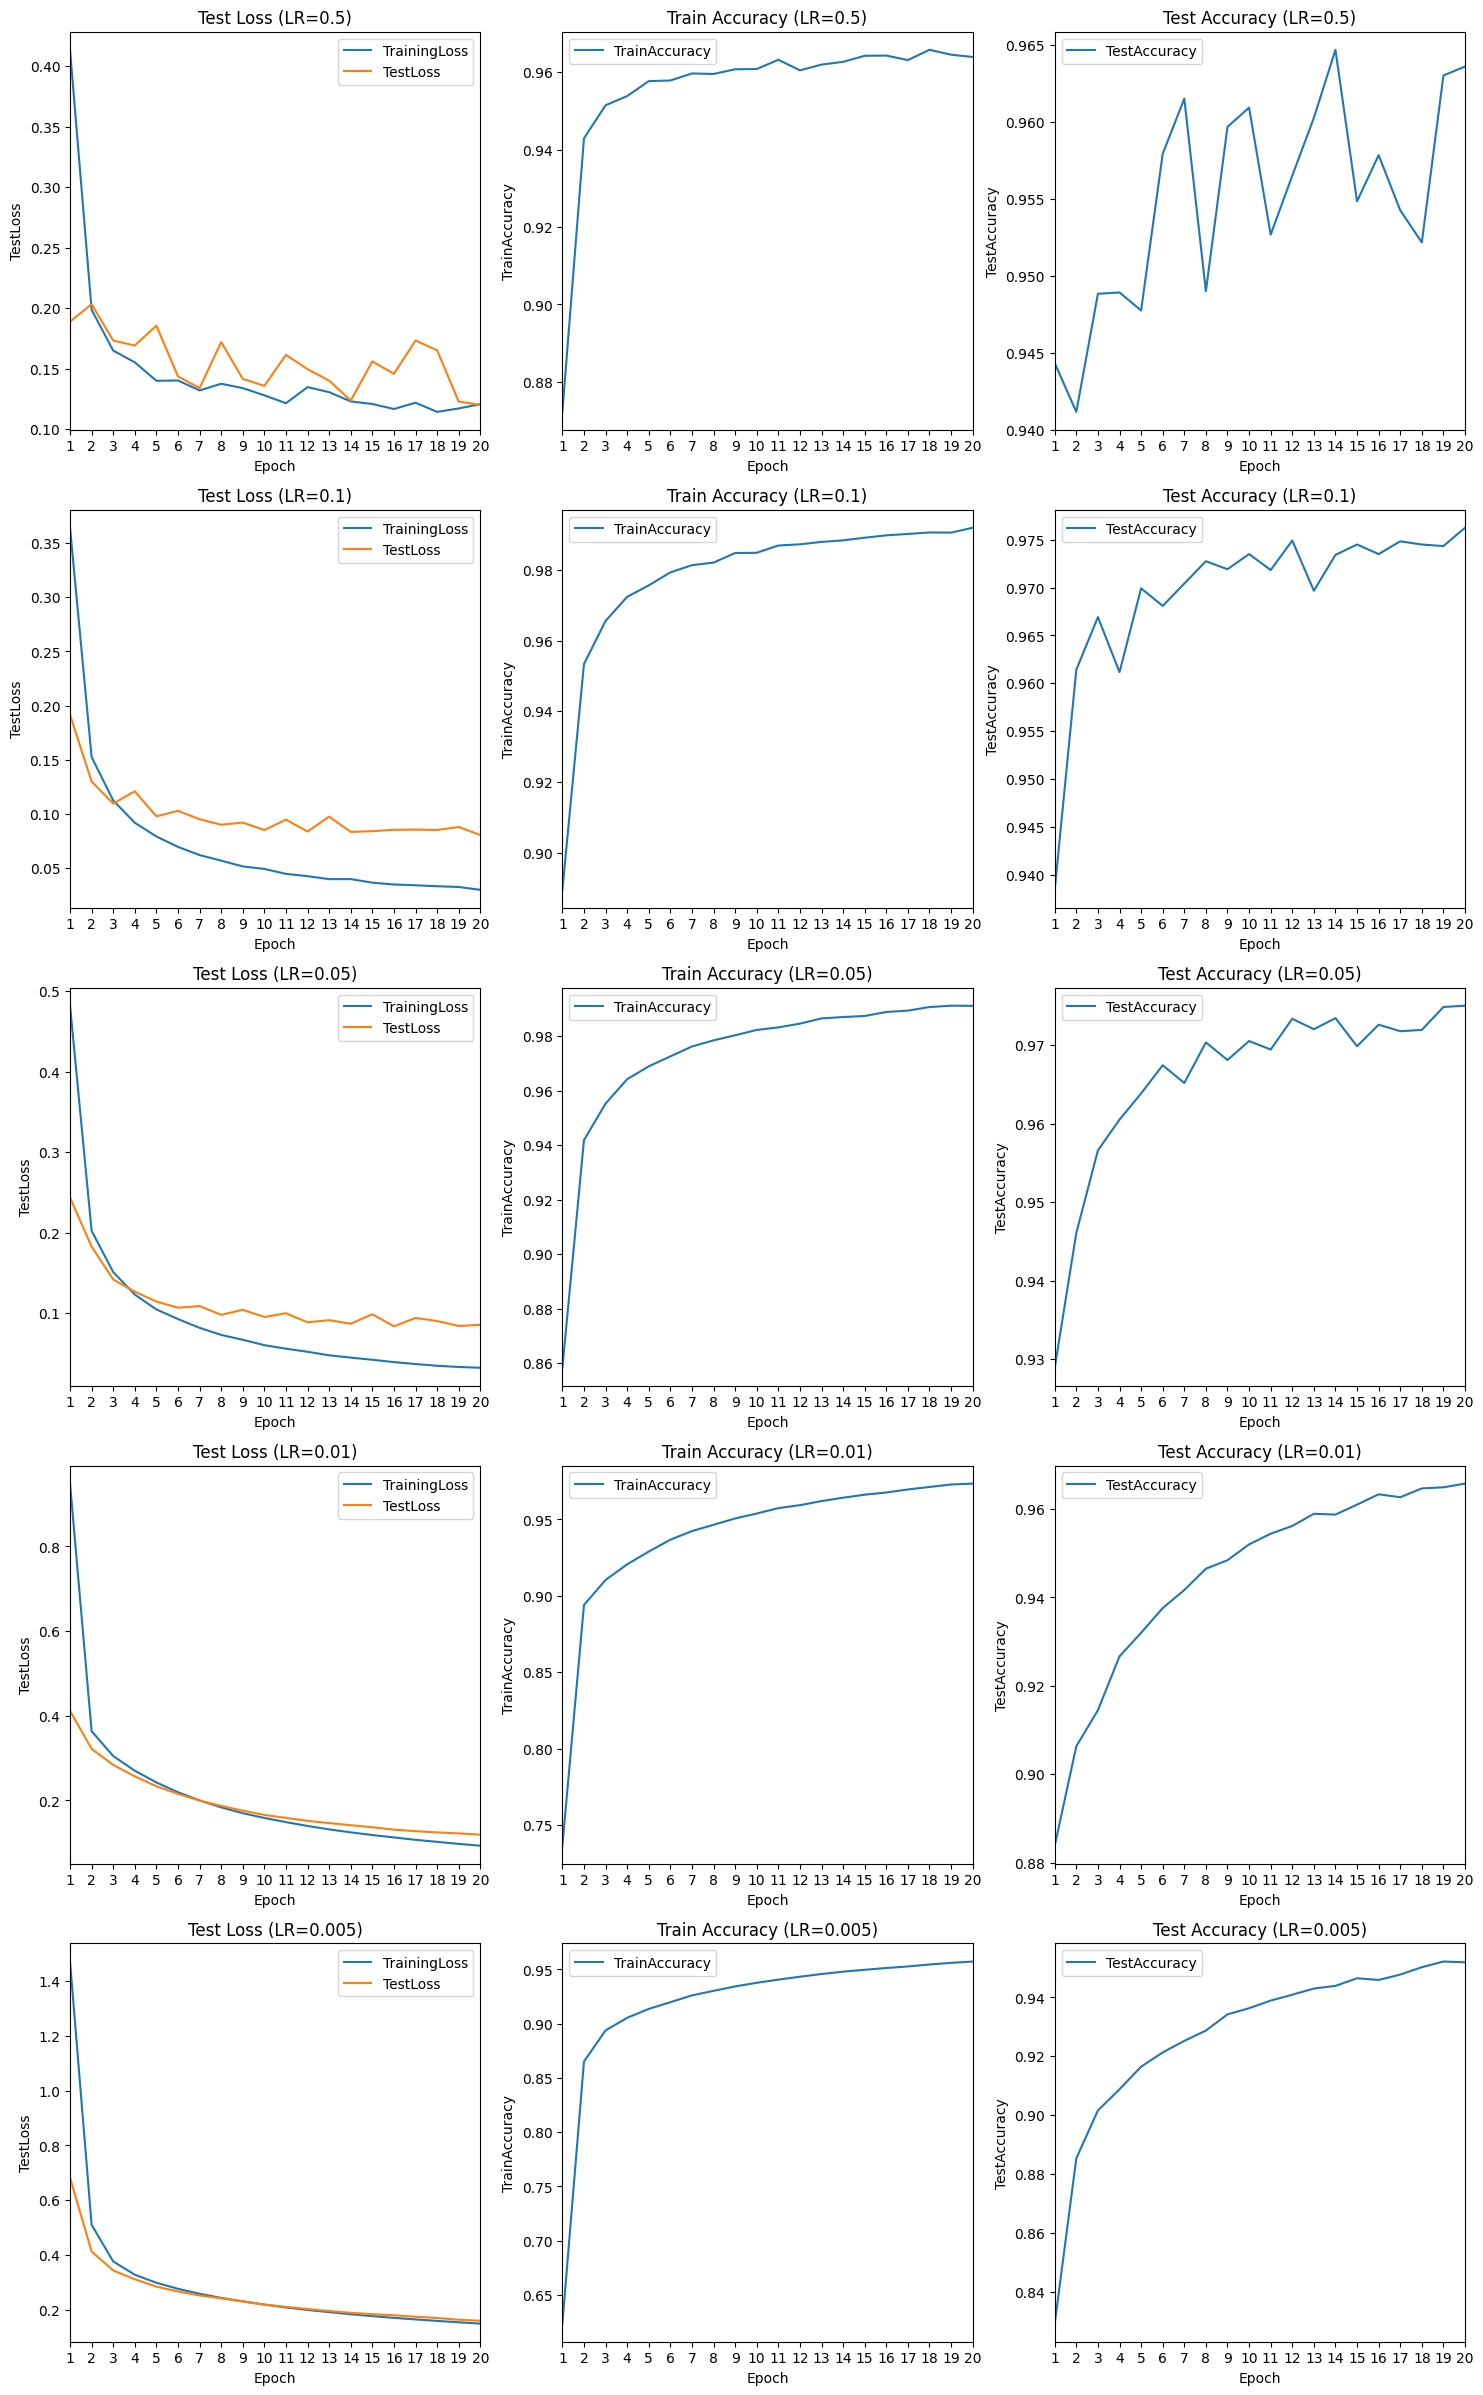

In [101]:
rates = [0.5, 0.1, 0.05, 0.01, 0.005]
inputsize = Train_images.shape[1]*Train_images.shape[2]
outputsize = 10

num_epochs = 20


fig, axs = plt.subplots(len(rates), 3, figsize=(18, 6 * len(rates)))

for i,l_rate in enumerate(rates):
  train_accuracies = []
  test_accuracies = []
  train_loss = []
  test_loss = []
  print("Learning Rate:",l_rate)

  model = MLP(inputsize, outputsize)
  optimizer = optim.SGD(model.parameters(),lr = l_rate,weight_decay = 0.001)
  criterion = nn.CrossEntropyLoss()

  test_accuracy, testing_loss = evaluate(model, test_loader, criterion)
  training_accuracy, training_loss = evaluate(model, train_loader, criterion)

  print(">>Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(training_accuracy, training_loss, test_accuracy, testing_loss))

  for epoch in range(num_epochs):

    train_accuracy, training_loss = train(model, train_loader, optimizer, criterion)
    test_accuracy, testing_loss = evaluate(model, test_loader, criterion)

    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    train_loss.append(training_loss)
    test_loss.append(testing_loss)

    print(">>Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(train_accuracy, training_loss, test_accuracy, testing_loss))

  epochs = list(range(1, num_epochs + 1))
  axs[i,0].plot(epochs, train_loss, label = 'TrainingLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TrainingLoss')
  axs[i,0].set_title(f'Training Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,0].plot(epochs, test_loss, label = 'TestLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TestLoss')
  axs[i,0].set_title(f'Test Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,1].plot(epochs, train_accuracies, label = 'TrainAccuracy')
  axs[i,1].set_xlabel('Epoch')
  axs[i,1].set_ylabel('TrainAccuracy')
  axs[i,1].set_title(f'Train Accuracy (LR={l_rate})')
  axs[i,1].legend()
  axs[i,1].set_xticks(epochs)
  axs[i,1].set_xlim(1,num_epochs)


  axs[i,2].plot(epochs, test_accuracies, label = 'TestAccuracy')
  axs[i,2].set_xlabel('Epoch')
  axs[i,2].set_ylabel('TestAccuracy')
  axs[i,2].set_title(f'Test Accuracy (LR={l_rate})')
  axs[i,2].legend()
  axs[i,2].set_xticks(epochs)
  axs[i,2].set_xlim(1,num_epochs)
